# DeepWeeds - Image Classification - Using ResNet50 Model

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import shutil

seed = 999
tf.random.set_seed(seed)

2024-03-06 07:02:34.831773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 07:02:34.831874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 07:02:34.961144: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [3]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/deepweeds/labels.csv") ## For Kaggle
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [4]:
data_info[['Species','Label']].groupby(by='Species').count().T

Species,Chinee apple,Lantana,Negative,Parkinsonia,Parthenium,Prickly acacia,Rubber vine,Siam weed,Snake weed
Label,1125,1064,9106,1031,1022,1062,1009,1074,1016


In [5]:
label2id = data_info[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label

{0: 'Chinee apple',
 1: 'Lantana',
 8: 'Negative',
 2: 'Parkinsonia',
 3: 'Parthenium',
 4: 'Prickly acacia',
 5: 'Rubber vine',
 6: 'Siam weed',
 7: 'Snake weed'}

In [6]:
low_data_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels with very low data
low_data_labels

array([0, 1, 7, 6, 4, 3, 5, 2])

# Splitting Data into Train:Valid:Test Splits (60:40:40)

In [7]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = 2 # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

# skfold = StratifiedKFold()
# kSplits = skfold.split(data_info['Filename'], y=data_info['Label'])
# for index in range(skfold.get_n_splits()):
#     train_index, test_index = next(kSplits)
#     if index == split_index:
#         break
        
# # trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# # train_data = pd.DataFrame({"Filename":trax,"label":tray})

# # trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# # valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# # test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 3 out of 5 folds
-------------------------------------------------



In [8]:
## Using Folds Used in The DeepWeeds Paper
train_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/train_subset{}.csv'.format(split_index)) ## for GoogleColab
train_data.rename(columns={"Label":"label"}, inplace=True)

valid_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/val_subset{}.csv'.format(split_index)) ## for GoogleColab
valid_data.rename(columns={"Label":"label"}, inplace=True)
test_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/test_subset{}.csv'.format(split_index)) ## for GoogleColab
test_data.rename(columns={"Label":"label"}, inplace=True)

print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
print("Train Data\n--------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("Validation Data\n--------\n",valid_data.groupby(by='label').count().T, "\tTotal:", valid_data.shape)
print("Test Data\n--------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  676  638  619  613  637  605  644  610  5464 	Total: (10506, 2)
Validation Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  212  206  205  213  202  215  203  1821 	Total: (3502, 2)
Test Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  204  212  202  215  203  1821 	Total: (3501, 2)


# Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)

In [9]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['Filename']
        label = row['label']

        source = os.path.join(source_dir,filename)
        
        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [10]:
from sklearn.utils import class_weight

def getWeightedClass(data, power=1, col="Label"):

    class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(data_info[col]),
                                                 y=data_info[col])

    return  { label: pow(class_weights[label],power) for label in range(len(class_weights)) }

getWeightedClass(data_info)

{0: 1.729283950617284,
 1: 1.8284252297410193,
 2: 1.8869490246793836,
 3: 1.9035659926070885,
 4: 1.8318685917555975,
 5: 1.9280916198656535,
 6: 1.8114007862611214,
 7: 1.9148075240594926,
 8: 0.21364423945139957}

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()
    
    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP
        
        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)
        
        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)
        
        false_rate.append((fP_Rate,accuracy))
    
    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()          
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()      
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]
    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=45 #'vertical'
    )
    #cmd.plot()
    plt.show()
    
def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model.predict_on_batch(batch[0])))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    
    total_epoch = len(acc)
    if 'peaks' in history:
        peaks = history['peaks']
    else:        
        peaks = [0 if total_epoch<=6 else total_epoch-6]
    
    epochs = range(total_epoch)
    print("Total Epochs:",total_epoch)
    
    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()
      
    plt.show()

# Creating Dateset ImageGenerator

In [12]:
IMG_SIZE=(256,256,3)
oversampling = 1 # How many times are we gonna over sample

if oversampling:
    print("Oversampling",oversampling,"times for labels",low_data_labels)

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/deepweeds/images" ## For Kaggle
base_dir = "/kaggle/working/deepweeds_9c" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Validation Data
organize_data_to_directory(valid_data, source_dir=input_dir, target_dir=validation_dir)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

Oversampling 1 times for labels [0 1 7 6 4 3 5 2]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [13]:
train_generator = getDatasetGenerators(
      train_dir,
      batch_size=32,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=16,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=False
)

validation_generator = getDatasetGenerators(
      validation_dir,
      batch_size=16,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

Found 15548 files belonging to 9 classes.
Found 3501 files belonging to 9 classes.
Found 3502 files belonging to 9 classes.


# Displaying Sample Images

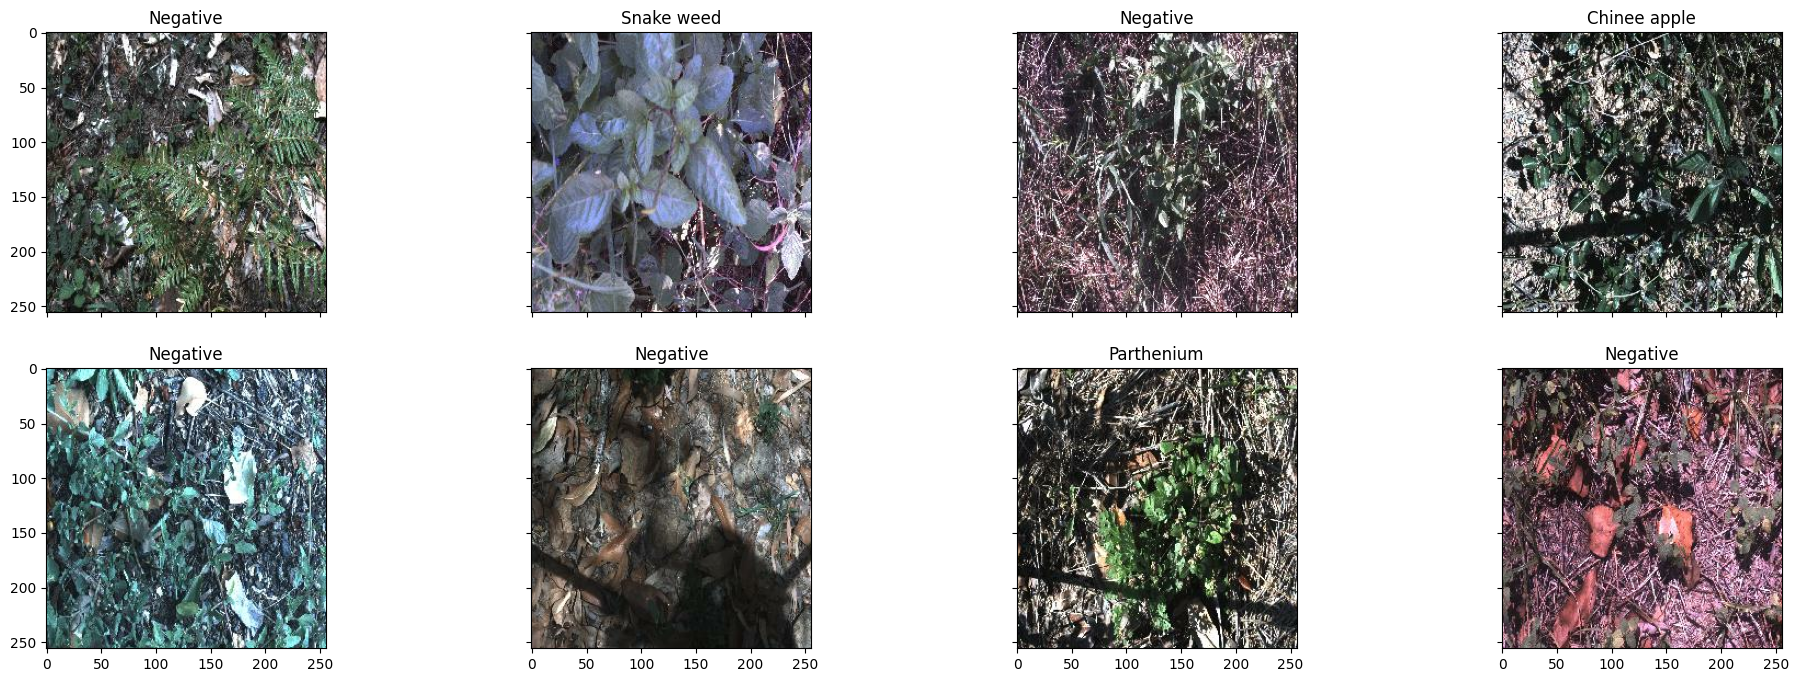

In [14]:
#image visualization

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

# ResNet50

In [15]:
# prompt: code to implement resnet

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.applications import ResNet50V2, resnet_v2

IMG_SIZE = (256,256,3)
seed=666
def buildResNetModel(train_resnet=False):
    # Load the ResNet50 model with weights pre-trained on ImageNet.
    base_model = resnet_v2.ResNet50V2(weights='imagenet', include_top=False)
    base_model.trainable = train_resnet
    print("Base Model:", base_model.name)

    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE)

    # Pre-process the input.
    x = layers.Rescaling(1./255)(inputs)
    # x = layers.Resizing(224, 224)(x)
    
    ## DAta Augmentation
    x = layers.RandomBrightness(0.25, (0, 1),seed=seed)(x)
    x = layers.RandomContrast(0.1, seed=seed)(x)
    x = layers.GaussianDropout(0.05, seed=seed)(x)
    x = layers.RandomFlip(seed=seed)(x)
    x = layers.RandomRotation(0.5, seed=seed)(x)
    x = layers.RandomTranslation(0.2, 0.2, seed=seed)(x)
    x = layers.RandomZoom(0.2, 0.2, seed=seed)(x)

    # Pass the input through the pre-trained InceptionV3 model.
    x = base_model(x, training=train_resnet)    
    x = layers.Dropout(0.2)(x) 
    
    ## Add a global average pooling layer.
    x = layers.AveragePooling2D(4)(x)
    x = layers.Flatten()(x)
    
    outputs = layers.Dense(9, activation='softmax')(x)

    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name='DeepWeeds-ResNet50')
    return model

In [16]:
model = buildResNetModel(train_resnet=True)
model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Base Model: resnet50v2
Model: "DeepWeeds-ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 random_brightness (RandomB  (None, 256, 256, 3)       0         
 rightness)                                                      
                                                                 
 random_contrast (RandomCon  (None, 256, 256, 3)       0         
 trast)                                                          
                                                                 
 gaussian_dropout (Gaussian  (None, 256, 256, 3)       0         
 Dropout)                 

# Trial 1

In [17]:
from tensorflow.keras.optimizers import RMSprop, AdamW

# Constant for epochs
EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=2e-4,  weight_decay=3e-2),
          metrics=['accuracy'])
# weights = getWeightedClass(data_info, 1/3)
# weights

Epoch 1/100


2024-03-06 07:06:10.713259: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-ResNet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1709708776.697032      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


486/486 [==============================] - 159s 260ms/step - loss: 1.0602 - accuracy: 0.6219 - val_loss: 0.7621 - val_accuracy: 0.7270
Epoch 2/100
486/486 [==============================] - 122s 250ms/step - loss: 0.6986 - accuracy: 0.7555 - val_loss: 0.5964 - val_accuracy: 0.7984
Epoch 3/100
486/486 [==============================] - 121s 250ms/step - loss: 0.5908 - accuracy: 0.7945 - val_loss: 0.5311 - val_accuracy: 0.8235
Epoch 4/100
486/486 [==============================] - 121s 249ms/step - loss: 0.5229 - accuracy: 0.8184 - val_loss: 0.4983 - val_accuracy: 0.8284
Epoch 5/100
486/486 [==============================] - 121s 250ms/step - loss: 0.4782 - accuracy: 0.8335 - val_loss: 0.4731 - val_accuracy: 0.8381
Epoch 6/100
486/486 [==============================] - 121s 249ms/step - loss: 0.4437 - accuracy: 0.8434 - val_loss: 0.4559 - val_accuracy: 0.8435
Epoch 7/100
486/486 [==============================] - 122s 250ms/step - loss: 0.4157 - accuracy: 0.8564 - val_loss: 0.4446 - val_

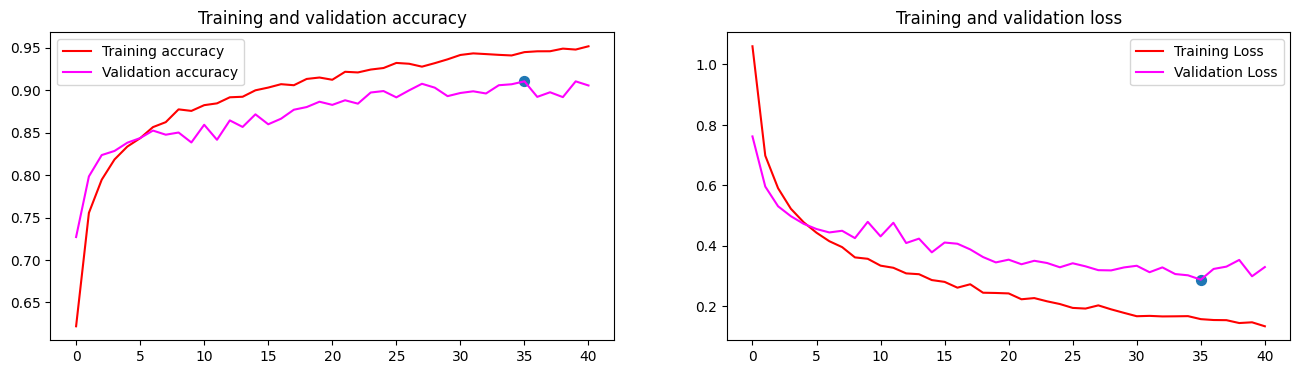

CPU times: user 1h 15min 15s, sys: 2min 41s, total: 1h 17min 57s
Wall time: 1h 23min 57s


In [18]:
%%time

# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
      #class_weight=weights
    )

print("Saving the Model")
model.save("DeepWeeds-ResNet50-Model.keras")

# Plot training results
plot_loss_acc(history1.history)

model.evaluate
219/219 [==============================] - 9s 41ms/step - loss: 0.3103 - accuracy: 0.9109
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.78431   0.88889   0.83333       225
       Lantana    0.88208   0.88208   0.88208       212
   Parkinsonia    0.94258   0.95631   0.94940       206
    Parthenium    0.83556   0.91707   0.87442       205
Prickly acacia    0.91388   0.89671   0.90521       213
   Rubber vine    0.76587   0.95545   0.85022       202
     Siam weed    0.90950   0.93488   0.92202       215
    Snake weed    0.77729   0.87685   0.82407       203
      Negative    0.96805   0.89841   0.93193      1821

      accuracy                        0.90548      3502
     macro avg    0.86435   0.91185   0.88585      3502
  weighted avg    0.91218   0.90548   0.90704      3502


                False Positive Rate  Accuracy
Chinee apple               0.016784  0.888889
Lantana                    0.007599  0.882075
Parkinsonia                0.003641  0.956311
Parthenium                 0.011222  0.917073
Prickly acacia    

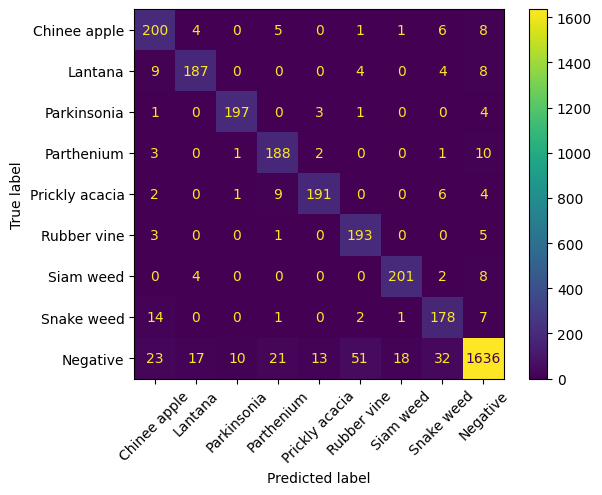

In [19]:
a, b = eval_model(model, validation_generator)

# Trial 2

Epoch 1/100


2024-03-06 08:30:43.197482: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-ResNet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


486/486 [==============================] - 148s 253ms/step - loss: 0.1034 - accuracy: 0.9648 - val_loss: 0.2383 - val_accuracy: 0.9220
Epoch 2/100
486/486 [==============================] - 122s 251ms/step - loss: 0.0774 - accuracy: 0.9731 - val_loss: 0.2370 - val_accuracy: 0.9332
Epoch 3/100
486/486 [==============================] - 122s 251ms/step - loss: 0.0750 - accuracy: 0.9751 - val_loss: 0.2389 - val_accuracy: 0.9335
Epoch 4/100
486/486 [==============================] - 122s 250ms/step - loss: 0.0667 - accuracy: 0.9764 - val_loss: 0.2253 - val_accuracy: 0.9306
Epoch 5/100
486/486 [==============================] - 122s 251ms/step - loss: 0.0627 - accuracy: 0.9777 - val_loss: 0.2412 - val_accuracy: 0.9295
Epoch 6/100
486/486 [==============================] - 122s 251ms/step - loss: 0.0611 - accuracy: 0.9801 - val_loss: 0.2378 - val_accuracy: 0.9315
Epoch 7/100
486/486 [==============================] - 122s 250ms/step - loss: 0.0531 - accuracy: 0.9822 - val_loss: 0.2225 - val_

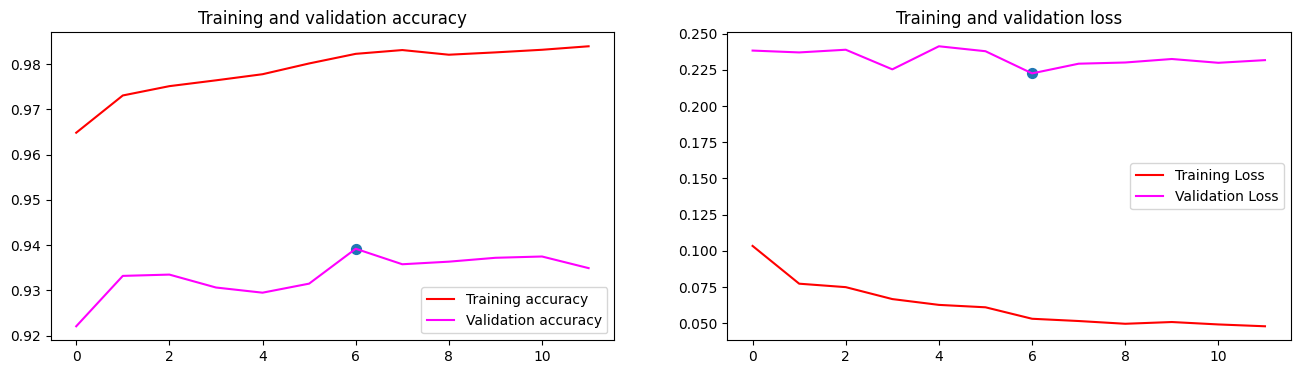

CPU times: user 22min 10s, sys: 48.3 s, total: 22min 58s
Wall time: 24min 49s


In [20]:
%%time
model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=2e-5,  weight_decay=3e-4),
          metrics=['accuracy'])

# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
    )

print("Saving the Checkpoint")
model.save("DeepWeeds-ResNet50-Model.keras")

# Plot training results
plot_loss_acc(history2.history)

model.evaluate
219/219 [==============================] - 9s 41ms/step - loss: 0.2326 - accuracy: 0.9326
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.86441   0.90667   0.88503       225
       Lantana    0.90411   0.93396   0.91879       212
   Parkinsonia    0.92558   0.96602   0.94537       206
    Parthenium    0.91981   0.95122   0.93525       205
Prickly acacia    0.88462   0.97183   0.92617       213
   Rubber vine    0.90323   0.97030   0.93556       202
     Siam weed    0.90868   0.92558   0.91705       215
    Snake weed    0.90148   0.90148   0.90148       203
      Negative    0.97138   0.93191   0.95123      1821

      accuracy                        0.93604      3502
     macro avg    0.90925   0.93988   0.92399      3502
  weighted avg    0.93761   0.93604   0.93632      3502


                False Positive Rate  Accuracy
Chinee apple               0.009765  0.906667
Lantana                    0.006383  0.933962
Parkinsonia                0.004854  0.966019
Parthenium                 0.005156  0.951220
Prickly acacia    

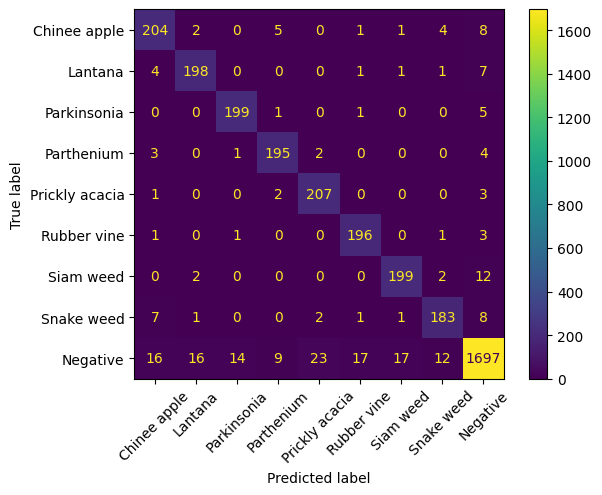

In [21]:
a, b = eval_model(model, validation_generator)

# Trial 3 - Frozen Base Model Layer

Epoch 1/100


2024-03-06 08:56:11.305809: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-ResNet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


486/486 [==============================] - 148s 253ms/step - loss: 0.0530 - accuracy: 0.9812 - val_loss: 0.2288 - val_accuracy: 0.9355
Epoch 2/100
486/486 [==============================] - 122s 251ms/step - loss: 0.0499 - accuracy: 0.9837 - val_loss: 0.2220 - val_accuracy: 0.9352
Epoch 3/100
486/486 [==============================] - 122s 251ms/step - loss: 0.0482 - accuracy: 0.9837 - val_loss: 0.2388 - val_accuracy: 0.9355
Epoch 4/100
486/486 [==============================] - 122s 252ms/step - loss: 0.0505 - accuracy: 0.9822 - val_loss: 0.2127 - val_accuracy: 0.9380
Epoch 5/100
486/486 [==============================] - 122s 251ms/step - loss: 0.0473 - accuracy: 0.9843 - val_loss: 0.2229 - val_accuracy: 0.9369
Epoch 6/100
486/486 [==============================] - 122s 251ms/step - loss: 0.0457 - accuracy: 0.9849 - val_loss: 0.2387 - val_accuracy: 0.9360
Epoch 7/100
486/486 [==============================] - 122s 251ms/step - loss: 0.0453 - accuracy: 0.9849 - val_loss: 0.2333 - val_

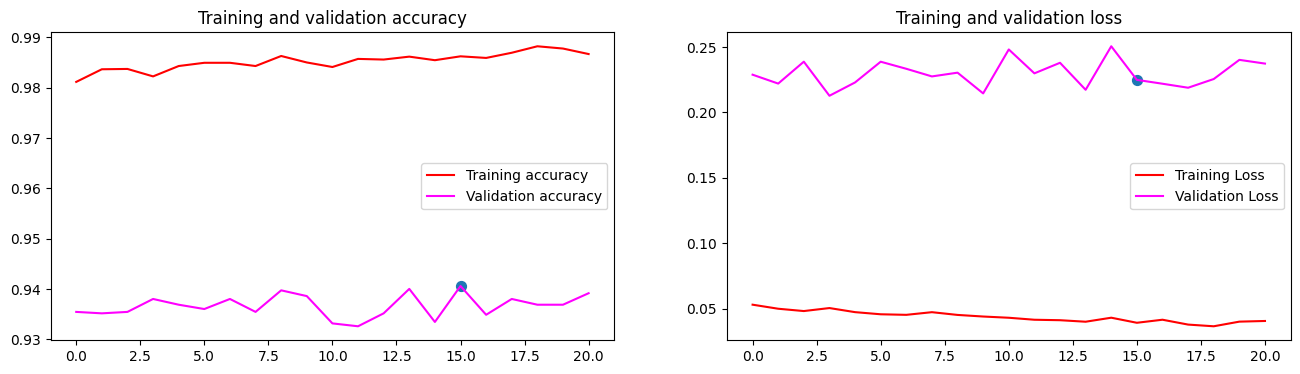

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
        
model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=5e-6,  weight_decay=1e-5),
          metrics=['accuracy'])

# Train the model
history3 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
      #class_weight=weights
    )

print("Saving the Checkpoint")
model.save("DeepWeeds-ResNet50-Model.keras")

# Plot training results
plot_loss_acc(history3.history)

model.evaluate
219/219 [==============================] - 9s 41ms/step - loss: 0.2358 - accuracy: 0.9335
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.84034   0.88889   0.86393       225
       Lantana    0.90278   0.91981   0.91121       212
   Parkinsonia    0.95238   0.97087   0.96154       206
    Parthenium    0.92891   0.95610   0.94231       205
Prickly acacia    0.91031   0.95305   0.93119       213
   Rubber vine    0.91549   0.96535   0.93976       202
     Siam weed    0.93151   0.94884   0.94009       215
    Snake weed    0.85915   0.90148   0.87981       203
      Negative    0.96987   0.93685   0.95307      1821

      accuracy                        0.93718      3502
     macro avg    0.91230   0.93791   0.92477      3502
  weighted avg    0.93853   0.93718   0.93754      3502


                False Positive Rate  Accuracy
Chinee apple               0.011596  0.888889
Lantana                    0.006383  0.919811
Parkinsonia                0.003034  0.970874
Parthenium                 0.004550  0.956098
Prickly acacia    

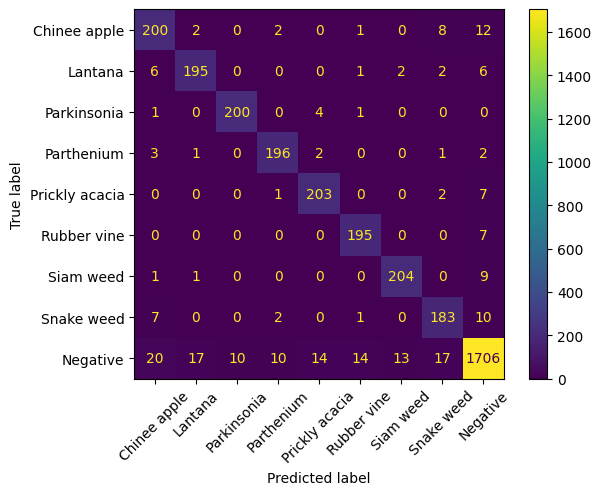

In [23]:
a, b = eval_model(model, validation_generator)

# Trail 4

Freezing layer resnet50v2
Epoch 1/100


2024-03-06 09:39:59.149885: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-ResNet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


486/486 [==============================] - 51s 96ms/step - loss: 0.1944 - accuracy: 0.9359 - val_loss: 0.1763 - val_accuracy: 0.9543
Epoch 2/100
486/486 [==============================] - 46s 95ms/step - loss: 0.1930 - accuracy: 0.9353 - val_loss: 0.1741 - val_accuracy: 0.9563
Epoch 3/100
486/486 [==============================] - 46s 95ms/step - loss: 0.1884 - accuracy: 0.9368 - val_loss: 0.1723 - val_accuracy: 0.9575
Epoch 4/100
486/486 [==============================] - 46s 95ms/step - loss: 0.1846 - accuracy: 0.9378 - val_loss: 0.1707 - val_accuracy: 0.9577
Epoch 5/100
486/486 [==============================] - 46s 94ms/step - loss: 0.1852 - accuracy: 0.9373 - val_loss: 0.1694 - val_accuracy: 0.9583
Epoch 6/100
486/486 [==============================] - 46s 94ms/step - loss: 0.1752 - accuracy: 0.9424 - val_loss: 0.1684 - val_accuracy: 0.9586
Epoch 7/100
486/486 [==============================] - 46s 94ms/step - loss: 0.1712 - accuracy: 0.9410 - val_loss: 0.1676 - val_accuracy: 0.95

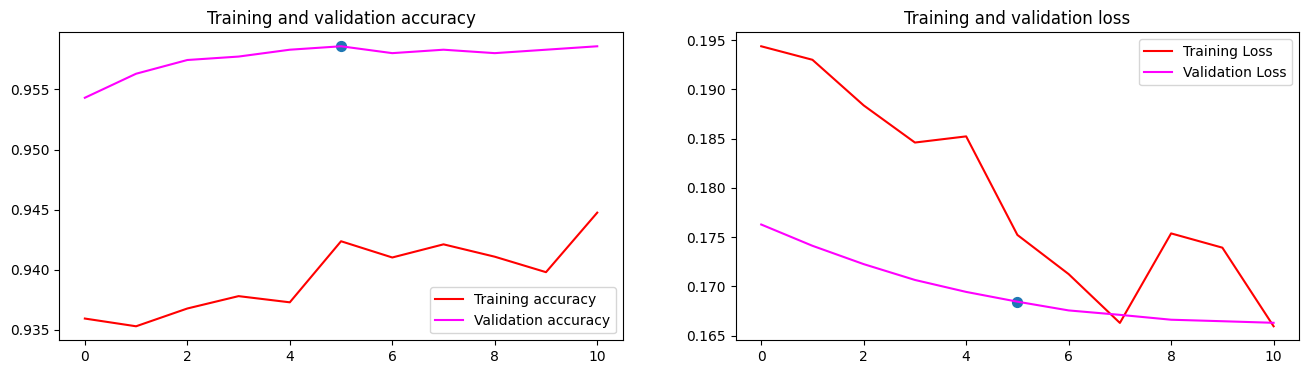

CPU times: user 7min 3s, sys: 34.8 s, total: 7min 38s
Wall time: 8min 33s


In [24]:
%%time
for layer in model.layers:
    if layer.name == 'resnet50v2':
        print("Freezing layer", layer.name)
        layer.trainable = False
        
model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=1e-6,  weight_decay=1e-6),
          metrics=['accuracy'])

# Train the model
history4 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
      #class_weight=weights
    )

print("Saving the Checkpoint")
model.save("DeepWeeds-ResNet50-Model.keras")

# Plot training results
plot_loss_acc(history4.history)

model.evaluate
219/219 [==============================] - 8s 38ms/step - loss: 0.1684 - accuracy: 0.9586
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.90625   0.90222   0.90423       225
       Lantana    0.93119   0.95755   0.94419       212
   Parkinsonia    0.97156   0.99515   0.98321       206
    Parthenium    0.93897   0.97561   0.95694       205
Prickly acacia    0.93578   0.95775   0.94664       213
   Rubber vine    0.95673   0.98515   0.97073       202
     Siam weed    0.95833   0.96279   0.96056       215
    Snake weed    0.88372   0.93596   0.90909       203
      Negative    0.98145   0.95881   0.97000      1821

      accuracy                        0.95860      3502
     macro avg    0.94044   0.95900   0.94951      3502
  weighted avg    0.95922   0.95860   0.95874      3502


                False Positive Rate  Accuracy
Chinee apple               0.006408  0.902222
Lantana                    0.004559  0.957547
Parkinsonia                0.001820  0.995146
Parthenium                 0.003943  0.975610
Prickly acacia    

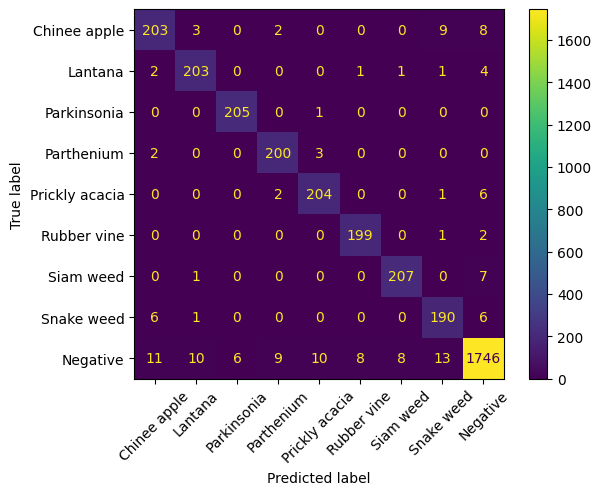

In [25]:
a, b = eval_model(model, validation_generator)

# Evaluations

Total Epochs: 85


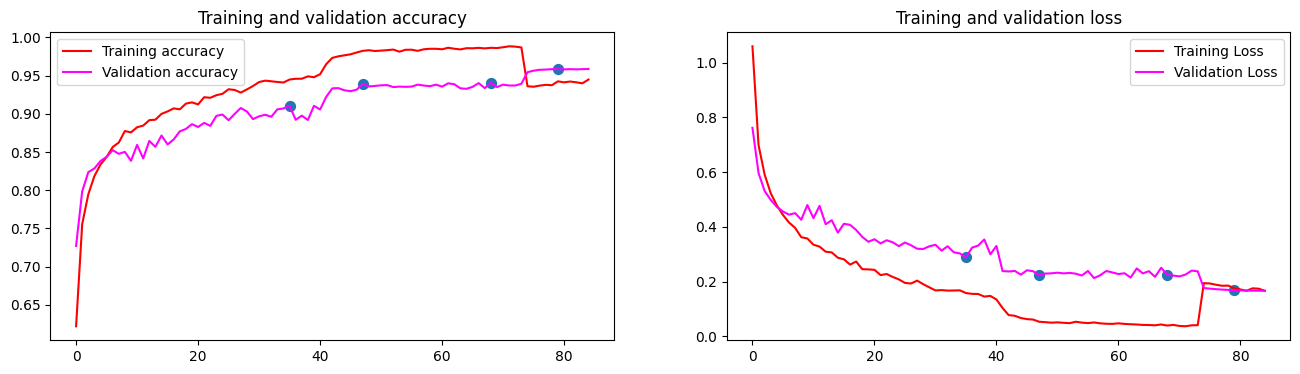

In [26]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])
    history[key].extend(history3.history[key])
    history[key].extend(history4.history[key])
    

h1len = len(history1.history['accuracy'])  
h2len = len(history2.history['accuracy'])
h3len = len(history3.history['accuracy'])
h4len = len(history4.history['accuracy'])
history['peaks'] = [h1len-6, (h1len+h2len)-6, (h1len+h2len+h3len)-6, 
                    (h1len+h2len+h3len+h4len)-6]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

In [27]:
## Computing Positive Threshold Using Validation Dataset
thresholds = []
for i in range(len(a)):
    n_label = prediction_argmax(b[i])
    ap_label = np.argmax(b[i])
    a_label = a[i]

    if(n_label == a_label):
        thresholds.append(b[n_label])


rand_guess = np.mean(thresholds)
"Threshold = {}".format(rand_guess)

'Threshold = 0.1111111119389534'

## Normal Evaluation

Normal Evaluation   
--------------------------------------------------------------------
model.evaluate
219/219 [==============================] - 9s 43ms/step - loss: 0.1775 - accuracy: 0.9543
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.89316   0.92889   0.91068       225
       Lantana    0.90583   0.94836   0.92661       213
   Parkinsonia    0.94037   0.99515   0.96698       206
    Parthenium    0.94686   0.96078   0.95377       204
Prickly acacia    0.91781   0.94811   0.93271       212
   Rubber vine    0.93689   0.95545   0.94608       202
     Siam weed    0.95516   0.99070   0.97260       215
    Snake weed    0.91262   0.92611   0.91932       203
      Negative    0.98244   0.95222   0.96709      1821

      accuracy                        0.95430      3501
     macro avg    0.93235   0.95620   0.94398      3501
  weighted avg    0.95523   0.95430   0.95450      3501


                False Positive Rate  Accuracy
Chinee apple               0.007631  0.928889
Lantana                    0.006387  0.948357
Parkinsonia                0.003945  0.995146
Parthenium                 0.003336  0.960784
Prickly acacia    

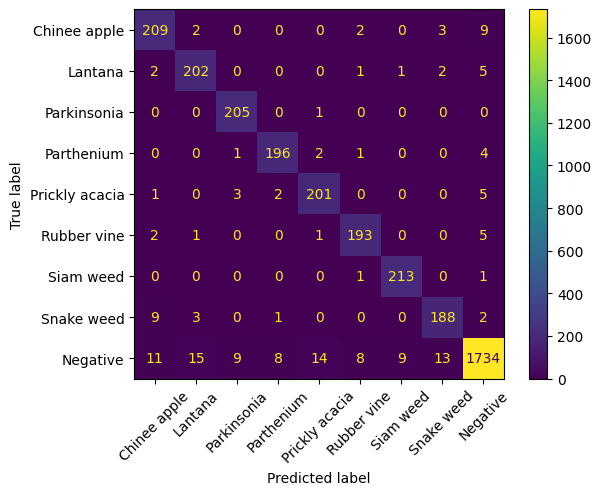

In [28]:
print("Normal Evaluation \
  \n--------------------------------------------------------------------")
a, b = eval_model(model, test_generator)

## Random Guess Threshold
> As applied by the paper DeepWeeds

Evaluation with Random Guess - As applied by the paper DeepWeeds   
--------------------------------------------------------------------
Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.84252   0.95111   0.89353       225
       Lantana    0.87879   0.95305   0.91441       213
   Parkinsonia    0.94037   0.99515   0.96698       206
    Parthenium    0.94686   0.96078   0.95377       204
Prickly acacia    0.87879   0.95755   0.91648       212
   Rubber vine    0.94146   0.95545   0.94840       202
     Siam weed    0.95536   0.99535   0.97494       215
    Snake weed    0.91262   0.92611   0.91932       203
      Negative    0.98783   0.93575   0.96108      1821

      accuracy                        0.94830      3501
     macro avg    0.92051   0.95892   0.93877      3501
  weighted avg    0.95104   0.94830   0.94882      3501


                False Positive Rate  Accuracy
Chinee apple               0.012210  0.951111
Lantana            

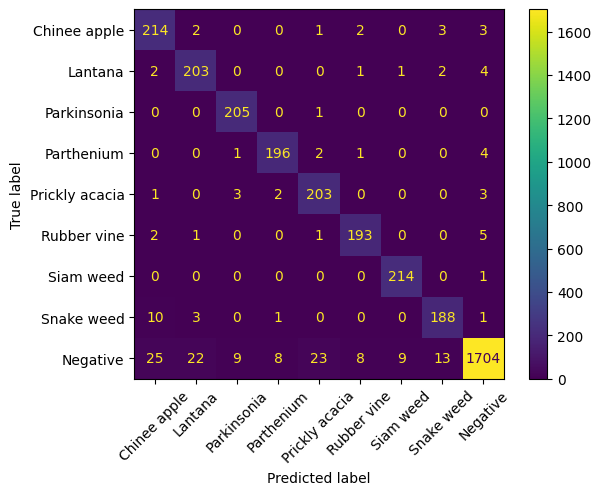

In [29]:
print("Evaluation with Random Guess - As applied by the paper DeepWeeds \
  \n--------------------------------------------------------------------")
printStats(a,b,rand_guess)

In [30]:
shutil.rmtree(base_dir)